# HiRES Net: Surrogate Modeling of the HiRES beamline at LBNL using TensorFlow/Keras


**Accelerators are extremely complex systems** which involve a large number of parameters, non-linear behavior and many interactive systems.

Different scientific/beam physics applications call for highly
automated, rapid switching between different operational
modes.

Conventional numerical simulation methods are
computational expensive and too slow to be directly used
during operation.

**Neural Networks(NN)** can be used to perform **fast predictions** of various electron pulse properties as well as the 6-dimensional phase space using nondestructive measurements as inputs. 

In this example, **TensorFlow/Keras** is used to build a **surrogate NN Model of the HiRES beamline**. A dataset of 2916 simulations is used for training and testing the model. From the machine learning point of view, this is formalized as a ***supervised learning problem***. Beamline parameters, such as RF gun phase and amplitude, buncher phase and amplitude as well as Solenoid current are inputs of the NN and the longitudinal phase space image is the output. The output is a continuous function of the input features so that it's a ***regression problem*** and ***Mean Square Error (MSE) loss function*** was choosen.


##Check GPU
Although the ultimate performance of the NN model will be similar, using GPUs can greatly accelerate the training process. Google Colab provides free access to one GPU for experiments. For local systems, training with one or more GPUs are recommended.

On the other hand, a CPU is well enough for excuting predictions with the trained model.

In [0]:
#check GPU
!nvidia-smi

Sun Sep  8 17:11:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

##Mount google drive 

Google drive can be used to train machine learning models on bigger dataset in the Google Colab environment. For local systems one can skip this step.

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##Go to the working folder
Go to the working folder of this example.

Data files should be put in a subfolder named as ".../datasets/"

In [0]:
cd /content/gdrive/My Drive/Colab Notebooks/HiRES_model/

/content/gdrive/My Drive/Colab Notebooks/HiRES_model


##Install tensoflow 2.0 and import modules

In [0]:
##Install tensorflow 2.0
!pip install tensorflow==2.0.0-beta1

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Load the TensorBoard notebook extension
%load_ext tensorboard

     |████████████████████████████████| 87.9MB 354kB/s 
     |████████████████████████████████| 3.1MB 29.9MB/s 
     |████████████████████████████████| 501kB 46.4MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [0]:
#check tensorflow version
print("tensorflow version:")
print(tf.__version__)
print("\n")

#check keras version
print("keras version:")
print(keras.__version__)
print("\n")

# check GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
print (tf.test.gpu_device_name()) 

tensorflow version:
2.0.0-beta1


keras version:
2.2.4-tf





##Load Dataset

Datasets are saved in h5 files and are loaded as numpy arrays. 

The array "x_orig" contains the input features (2916 one-dimensional vectors respresenting the beamline parameters) and "y_orig" contains the output images (2916 two-dimensional images of the longitudinal phase space)

In [0]:
##define the data loading function
def load_dataset():
    
    ############Load the 1st dataset###################################
    dataset = h5py.File('datasets/HiRES_ML_set1.h5', "r")
    dataset_x_orig = np.array(dataset["data_x"][:]) # your data set features
    dataset_y_orig = np.array(dataset["data_y"][:]) # your data set labels
    
    
    ############Append the 2nd dataset to the 1st dataset##################
    dataset = h5py.File('datasets/HiRES_ML_set2.h5', "r")
    
    dataset_x_orig_append = np.array(dataset["data_x_scan3"][:]) # your data set features
    dataset_y_orig_append = np.array(dataset["data_y_scan3"][:]) # your data set labels
        
    dataset_x_orig = np.concatenate((dataset_x_orig, dataset_x_orig_append), axis=0)
    dataset_y_orig = np.concatenate((dataset_y_orig, dataset_y_orig_append), axis=0)
    
    dataset_x_orig_append = np.array(dataset["data_x_scan4"][:]) # your data set features
    dataset_y_orig_append = np.array(dataset["data_y_scan4"][:]) # your data set labels
        
    dataset_x_orig = np.concatenate((dataset_x_orig, dataset_x_orig_append), axis=0)
    dataset_y_orig = np.concatenate((dataset_y_orig, dataset_y_orig_append), axis=0)
    
    dataset_x_orig_append = np.array(dataset["data_x_scan5"][:]) # your data set features
    dataset_y_orig_append = np.array(dataset["data_y_scan5"][:]) # your data set labels
        
    dataset_x_orig = np.concatenate((dataset_x_orig, dataset_x_orig_append), axis=0)
    dataset_y_orig = np.concatenate((dataset_y_orig, dataset_y_orig_append), axis=0)
    
    dataset_x_orig_append = np.array(dataset["data_x_scan6"][:]) # your data set features
    dataset_y_orig_append = np.array(dataset["data_y_scan6"][:]) # your data set labels
        
    dataset_x_orig = np.concatenate((dataset_x_orig, dataset_x_orig_append), axis=0)
    dataset_y_orig = np.concatenate((dataset_y_orig, dataset_y_orig_append), axis=0)
    
    ############Append the 3rd dataset to the 1st dataset##################
    dataset = h5py.File('datasets/HiRES_ML_set3.h5', "r")
    
    dataset_x_orig_append = np.array(dataset["data_x_scan7"][:]) # your data set features
    dataset_y_orig_append = np.array(dataset["data_y_scan7"][:]) # your data set labels
        
    dataset_x_orig = np.concatenate((dataset_x_orig, dataset_x_orig_append), axis=0)
    dataset_y_orig = np.concatenate((dataset_y_orig, dataset_y_orig_append), axis=0)
    
    dataset_x_orig_append = np.array(dataset["data_x_scan8"][:]) # your data set features
    dataset_y_orig_append = np.array(dataset["data_y_scan8"][:]) # your data set labels
        
    dataset_x_orig = np.concatenate((dataset_x_orig, dataset_x_orig_append), axis=0)
    dataset_y_orig = np.concatenate((dataset_y_orig, dataset_y_orig_append), axis=0)
    
    dataset_x_orig_append = np.array(dataset["data_x_scan9"][:]) # your data set features
    dataset_y_orig_append = np.array(dataset["data_y_scan9"][:]) # your data set labels
        
    dataset_x_orig = np.concatenate((dataset_x_orig, dataset_x_orig_append), axis=0)
    dataset_y_orig = np.concatenate((dataset_y_orig, dataset_y_orig_append), axis=0)
    
    
    #######################################
    
    
    #classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    #train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    #test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return dataset_x_orig,dataset_y_orig
  
  
  
#load dataset
x_orig, y_orig = load_dataset()
print(x_orig.shape)
print(y_orig.shape)

(2916, 3)
(2916, 301, 301)


##Plot an example image in the dataset

x = [  4.75 -90.    -1.2 ]


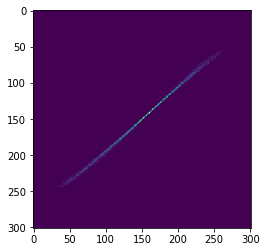

In [0]:
# Example of an image
index = 1600
plt.imshow(y_orig[index])

# print the corresponding input vector
print ("x = " + str(np.squeeze(x_orig[index,:])))

##Crop the output images 

The number of neurons in the output layer of the Neural Network is (n x m), where n and m are the output image size in the horizontal and vertical direction. Cropping the output images can reduce the size of neural networks and accelerate training. However, information contained in the phase space area further from the centroid could be lost. 

In this example, output images are cropped into half size so that the size of NN is reduced by a factor of 4.

(2916, 151, 151)
x = [  4.45 -85.    -1.4 ]


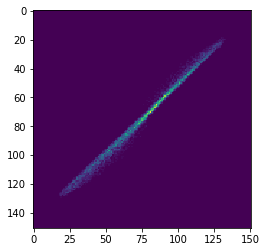

In [0]:
def crop_images(imagestack,xwidth,ywidth):
    ywidth_orig = imagestack.shape[1]
    xwidth_orig = imagestack.shape[2]
    ystart = math.floor((ywidth_orig-ywidth)/2)
    xstart = math.floor((xwidth_orig-xwidth)/2)
    
    #import pdb; pdb.set_trace()

    imagestack_crop = imagestack[:,ystart:(ystart+ywidth),xstart:(xstart+xwidth)]
    
    
    return imagestack_crop
  
  
##crop the images to (151,151) size
y_crop = crop_images(y_orig,xwidth = 151,ywidth = 151)
print(y_crop.shape)

# Example of an image
index = 1300
plt.imshow(y_crop[index])
print ("x = " + str(np.squeeze(x_orig[index,:])))


##Shuffle the dataset
The simulation dataset is sorted since it was generated by scanning the beamline parameters. 
By shuffling the data one can make sure that the training/validation/test sets are representive of the overall parameter space. Also by shuffling the data one can reduce variance/overfitting when training the model using mini-batch gradient descent.


In [0]:
def shuffle_data(xdata,ydata, seed = 1):
    #shuffle the data set
    #arguments: xdata, ydata
    #returns: shuffled_X, shuffled_Y
    m = xdata.shape[0]   #number of examples in data set
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    
    #import pdb; pdb.set_trace()  #debug
    
    shuffled_X = xdata[permutation,:]
    shuffled_Y = ydata[permutation,:]
    
    return shuffled_X, shuffled_Y
  
############shuffle the data set################
x_shuffle, y_shuffle = shuffle_data(x_orig, y_crop, seed =1)

##Feature Scaling
Scale the features so that they have the same range in the parameter space. This removes asymmetry and greately accelerates convergence during training using gradient descent.

In [0]:
## normalize input x
def normalize_input(xdata):
    #dimension = xdata.shape[1]
    #for i in range(dimension):
    avg = np.mean(xdata,axis = 0)
    std = np.std(xdata,axis = 0)
    print('the average values of the inputs:')
    print(avg)
    print('the standard deviation of the inputs:')
    print(std)
    xdata_norm = (xdata-avg)/std
    
    return xdata_norm,avg,std
  
x_shuffle_norm, avgx, stdx = normalize_input(x_shuffle)    ##normalize the input
y_shuffle_norm = y_shuffle/10   ##normalize the output

the average values of the inputs:
[   4.0291615 -100.          -1.5999943]
the standard deviation of the inputs:
[ 0.71486086 12.909945    0.25819746]


## Flatten the output images into 1D vectors

The output images are flattened into 1D vectors to match the shape of the  output layer of a fully-connected NN.

In [0]:
# Flatten the output
y_shuffle_flatten = y_shuffle_norm.reshape(y_shuffle_norm.shape[0],-1)

##Split the dataset 
The dataset is splitted into training, validation and test sets

(2100, 3)
(2100, 22801)
(400, 3)
(400, 22801)
(416, 3)
(416, 22801)
x = [0.16903798 0.         0.774579  ]


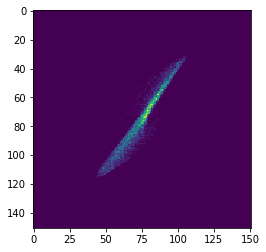

In [0]:
## split the data into training set and test set
def split_dataset(xdata,ydata, m_training = 2100, m_validation = 400):
    m = xdata.shape[0]
    x_train = xdata[0:m_training,:]
    y_train = ydata[0:m_training,:]

    x_validat = xdata[m_training:(m_training+m_validation),:]
    y_validat = ydata[m_training:(m_training+m_validation),:]
    
    x_test = xdata[(m_training+m_validation):m,:]
    y_test = ydata[(m_training+m_validation):m,:]
    
    return x_train,y_train,x_validat,y_validat,x_test,y_test
  
## split dataset into training set and test set
x_train,y_train,x_validat,y_validat,x_test,y_test = split_dataset(x_shuffle_norm,y_shuffle_flatten, m_training = 2100, m_validation = 400)
print(x_train.shape)
print(y_train.shape)

print(x_validat.shape)
print(y_validat.shape)

print(x_test.shape)
print(y_test.shape)


# Example of an image
index = 1120
plt.imshow(y_train[index].reshape(151,151))  #y need to be reshaped for display
print ("x = " + str(np.squeeze(x_train[index,:])))

##Building the NN model for predicting longitudinal phase space
A fully connected neural network is built for predicting the longitudinal phase space using the following achitecture:

1. **Input Layer**: number of neurons is equal to the input vector dimension
2. **Hidden Layer #1**: 50 neurons, with ReLU activation
3. **Hidden Layer #2**: 100 neurons, with ReLU activation
4. **Hidden Layer #3**: 200 neurons, with ReLU activation
5. **Output Layer**: number of the neurons is equal to the output vector dimension, with batchnormalization and ReLU activation

Note that, the NN achitecture can be further optimized by changing number of neurons per layer, number of layers, activation functions as well as adding BatchNorm/drop out operations. Further hyperparameter tuning can be used to improve the perfromance.

In [0]:
#############define the Neural Network using keras###################
outshape = y_train.shape[1]
inputshape = x_train.shape[1]

model = keras.Sequential([
    keras.layers.InputLayer((inputshape,)),
    keras.layers.Dense(50),
    #keras.layers.BatchNormalization(epsilon=1e-06, axis=-1,momentum=0.9,beta_initializer='zero', gamma_initializer='one'),
    keras.layers.Activation('relu'),
    #keras.layers.Dropout(0.2),
    
    keras.layers.Dense(100),
    #keras.layers.BatchNormalization(epsilon=1e-06, axis=-1,momentum=0.9,beta_initializer='zero', gamma_initializer='one'),
    keras.layers.Activation('relu'),
    #keras.layers.Dropout(0.2),
    
    keras.layers.Dense(200),
    #keras.layers.BatchNormalization(epsilon=1e-06, axis=-1,momentum=0.9,beta_initializer='zero', gamma_initializer='one'),
    keras.layers.Activation('relu'),
    #keras.layers.Dropout(0.2),
    
    #keras.layers.Dense(500),
    #keras.layers.BatchNormalization(epsilon=1e-06, axis=-1,momentum=0.9,beta_initializer='zero', gamma_initializer='one'),
    #keras.layers.Activation('relu'),
    #keras.layers.Dropout(0.2),
   
    
    keras.layers.Dense(outshape),
    keras.layers.BatchNormalization(epsilon=1e-06, axis=-1,momentum=0.9,beta_initializer='zero', gamma_initializer='one'),
    keras.layers.Activation('relu')
])


##Define customized metric function

In [0]:
##define customized metric functions
import keras.backend as K

# this function is a metric for tf tensors during training
def metric_score(y_true, y_pred):
    y_true_std = K.std(y_true,axis = -1)
    y_true_mean = K.mean(y_true, axis = -1)
    #score = 1-K.mean(K.square(y_pred - y_true), axis=-1)/K.mean(K.square(y_true-y_true_mean), axis = -1)
    score = 1-K.mean(K.square(y_pred - y_true), axis=-1)/y_true_std
    
    return score

# this function is a metric for numpy arrays
def output_score(y_true, y_pred):
    y_true_std = np.std(y_true,axis = -1)
    y_true_mean = np.mean(y_true, axis = -1)
    #score = 1-K.mean(K.square(y_pred - y_true), axis=-1)/K.mean(K.square(y_true-y_true_mean), axis = -1)
    score = 1-np.mean(np.square(y_pred - y_true), axis=-1)/y_true_std
    
    return score
  

Using TensorFlow backend.


##Compile the model
For convenience, Adam optimizer is choosen, Stochastic Gradient Descent (SGD) in general gives a better ultimate result but requires more hyperparameter tuning.

The output is a continuous function of the input features so that it's a regression problem and Mean Square Error (MSE) loss function was choosen.

In [0]:
##compile model
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=[metric_score])

##Update Learning curve during training

In [0]:
#############update loss during training#############

from IPython.display import clear_output

# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

##TensorBoard log during training

In [0]:
#############TensorBoard log####################
from time import time
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs_test/{}".format(time()), histogram_freq=10,write_grads=True, write_images=True)

##Train the Neural Network
Ready to train the network, run!

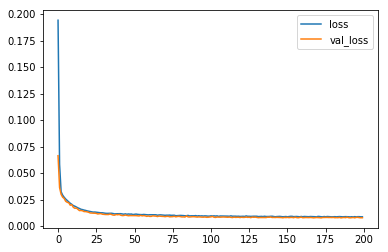

2100/2100 [==============================] - 6s 3ms/sample - loss: 0.0087 - metric_score: 0.9667 - val_loss: 0.0078 - val_metric_score: 0.9704


In [0]:
history = model.fit(x_train, y_train, 
          epochs=200,
          validation_data=(x_validat, y_validat),
          callbacks=[tensorboard_callback,plot_losses]
          #callbacks=[plot_losses]
         )

##Plot learning curves
Learning curve shows the training and validation loss over training epochs. It tells how much the NN can be improved by adding more training data or changing hyperparmeters and whether the model is limited by variance/ bias errors.

In this example, after 200 epoches of training, the training loss is still higher than the validation loss, which indicates that the NN is still under fitting. One can further improve the performance by trianing with more number of epoches or increasing number of neurons per layer/number of layers of the NN.

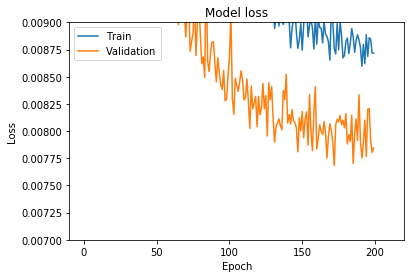

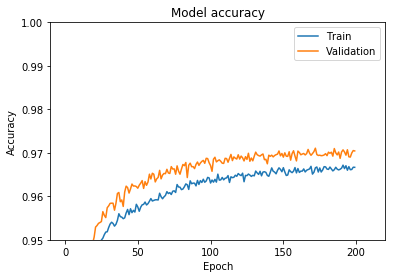

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])#, loc='upper right')
plt.axis([-10,220,0.007,0.009])
plt.show()

# Plot training & validation metric values
plt.plot(history.history['metric_score'])
plt.plot(history.history['val_metric_score'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])#, loc='bottom right')
plt.axis([-10,220,0.95,1])
plt.show()

##Call TensorBoard for visulizing the training
TensorBoard is a powerful visualization tool box.
One can use TensorBoard to visualize TensorFlow graph, plot quantitative metrics about the execution of the graph, and show additional data like images that pass through it. 

In [0]:
###########Call TensorBoard#############################
%tensorboard --logdir logs

##Evaluate the model on test set

Gives about 0.0075 loss and 0.97 metric score if train the model using default settings

In [0]:
test_loss, test_acc = model.evaluate(x_test, y_test)

416/416 [==============================] - 0s 518us/sample - loss: 0.0076 - metric_score: 0.9708


##Predict phase space using the trained Neural Network

In [0]:
##############make predictions using the fitted model##############
predictions = model.predict(x_test)
predictions.shape

(416, 22801)

##Comparison of the Simulated and NN predicted phase space 

The output layer of the neural networks is reshaped to a 2D image for visualizing.

Try change "index" to check different phase space images.

The correspoding metric score is calculated and displayed for reference

x = [  3.90000639 -79.99999864  -1.29999905]


The score is: 0.9765077121555805


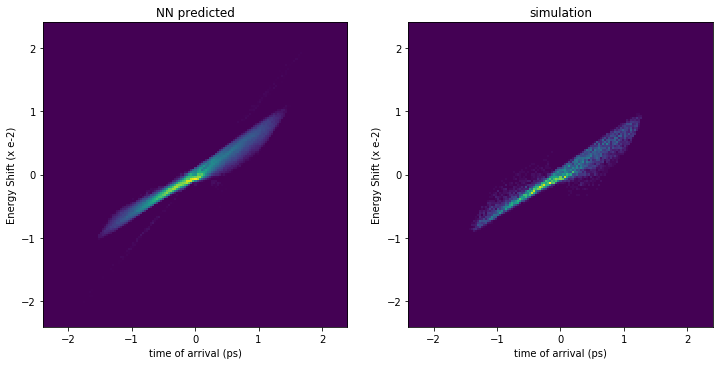

In [0]:
# import ndimage for removing the black spots using median filter
from scipy import ndimage


# define plot parameters

x_calib = 0.032
y_calib = 0.032

x_start = -1*x_calib*75
y_start = -1*y_calib*75

x_end = 1*x_calib*75
y_end = 1*y_calib*75

# Example of a prediction
# The image is transposed to meet the convention
index = 135

im_predict = predictions[index].reshape(151,151) #prediction using NN
im_med = ndimage.median_filter(im_predict, 1)    #apply median filter
im_test = y_test[index].reshape(151,151)         #y_test


#predicted phase space
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
#plt.imshow(predictions[index].reshape(151,151))  #prediction, y need to be reshaped to be displayed
im1 = plt.imshow(im_med.T,extent=[x_start,x_end,y_start,y_end])  #prediction, y need to be reshaped to be displayed
plt.xlabel('time of arrival (ps)')
plt.ylabel('Energy Shift (x e-2)')
plt.title('NN predicted')

#simulated phase space
plt.subplot(1,2,2)
plt.imshow(im_test.T,extent=[x_start,x_end,y_start,y_end])  #training data, y need to be reshaped to be displayed
plt.xlabel('time of arrival (ps)')
plt.ylabel('Energy Shift (x e-2)')
plt.title('simulation')



x_normalized = np.squeeze(x_test[index,:])  #restore x using the feature std and average
x_avg = np.array([   4.0291677, -100.,          -1.5999935])
x_std = np.array([ 0.71486056, 12.909945,    0.25819755])

x_restored = np.multiply(x_normalized,x_std)+x_avg

print ("x = " + str(x_restored))
print ("\n")
print ("The score is: "+str(output_score(y_test[index],predictions[index])))


##Comparison of the temporal profiles

Text(0, 0.5, 'intensity (arb. units)')

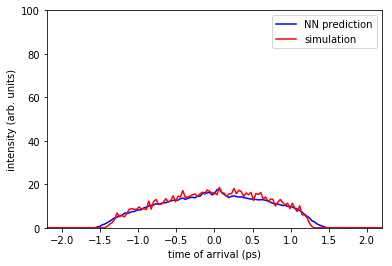

In [0]:
#temporal profile
temporal_predict = np.sum(im_predict, axis = 1)
temporal_test = np.sum(im_test, axis = 1)

energy_predict = np.sum(im_predict, axis = 0)
energy_test = np.sum(im_test, axis = 0)

x_calib = 0.032
xlabel = np.arange(151)
xlabel = xlabel*x_calib-75*x_calib

temporal_predict.shape

plt.figure(figsize=(6,4))
plt.plot(xlabel, temporal_predict,'b',label = 'NN prediction')
plt.plot(xlabel, temporal_test,'r', label = 'simulation')
plt.legend()
plt.axis([-2.2,2.2,0,100])

plt.xlabel('time of arrival (ps)')
plt.ylabel('intensity (arb. units)')

##Plot distributions of eneryg spread VS temporal length

In [0]:
#this function calculates the rms deviation of intensity profiles in an imagestack

def calculate_rms(imagestack):
    m = imagestack.shape[0]
    ysize = imagestack.shape[1]
    xsize = imagestack.shape[2]
    print ("number of images is: "+str(m))
    
    xprofiles = np.sum(imagestack, axis = 1)     # xprofile is in shape (416, 151)
    yprofiles = np.sum(imagestack, axis = 2)     # yprofile is in shape (416, 151)
    
    int_sum = np.sum(xprofiles, axis = 1, keepdims = 1)   # intensity integration
    #int_sum1 = np.sum(yprofiles, axis = 1, keepdims = 1)   # intensity integration for double check
   
    
    #create label arrays
    x_calib = 32e-5    
    xlabel = np.arange(0, xsize*x_calib, x_calib)    
    xlabel = xlabel.reshape(xsize,1)
    xlabel = xlabel.T       # xlabel is in shape (1,151)
    
    print('calibration of x is: '+str(x_calib))
    
    y_calib = 0.032    
    ylabel = np.arange(0, ysize*y_calib, y_calib)
    ylabel = ylabel.reshape(ysize,1)
    ylabel = ylabel.T      # ylabel is in shape (1,151)
    
    print('calibration of y is: '+str(y_calib))
    
    #calculate average of x and y
    
    x_temp = np.multiply(xprofiles, xlabel)
    y_temp = np.multiply(yprofiles, ylabel)
    
    x_mean = np.sum(x_temp,axis = 1, keepdims = 1)/int_sum  # xmean is in shape (416, 1)
    y_mean = np.sum(y_temp,axis = 1, keepdims = 1)/int_sum  # ymean is in shape (416, 1)
    
    print('x centor of mass is: '+str(x_mean[0]))   #check x_mean
    print('y centor of mass is: '+str(y_mean[0]))   # chec y_mean
    
    #calculate rms using average
    
    xlabel = np.broadcast_to(xlabel, (m, xsize)) # xlabel is in shape (416,151)
    ylabel = np.broadcast_to(ylabel, (m, ysize)) # ylabel is in shape (416,151)
    
    xlabel = xlabel - x_mean
    ylabel = ylabel - y_mean
    
    x_temp = np.multiply(xlabel,xlabel)
    y_temp = np.multiply(ylabel,ylabel)
    
    #print(x_temp)
    
    x_temp = np.multiply(x_temp, xprofiles)
    y_temp = np.multiply(y_temp, yprofiles)
    
    xx = np.sum(x_temp,axis = 1, keepdims = 1)/int_sum
    yy = np.sum(y_temp,axis = 1, keepdims = 1)/int_sum
    
    rms_x = np.sqrt(xx)
    rms_y = np.sqrt(yy)
    
    print ('rms x of 1st image is: '+str(rms_x[0]))
    print ('rms y of 1st image is: '+str(rms_y[0]))
    
    
    return rms_x, rms_y
  
  
## calculate the rms of energy spread and temporal length

# use the training data set
predictions_train = model.predict(x_train)


imagestack = predictions_train.reshape(predictions_train.shape[0],151,151)  #reshape the prediction data

rms_x_prediction, rms_y_prediction = calculate_rms(imagestack)


imagestack = y_train.reshape(y_train.shape[0],151,151)  

rms_x_simulation, rms_y_simulation = calculate_rms(imagestack)


## check the temporal focusing conditions

#print(rms_y_prediction[np.where(rms_y_prediction<0.2)])  
#print(np.where(rms_y_prediction<0.2))


number of images is: 2100
calibration of x is: 0.00032
calibration of y is: 0.032
x centor of mass is: [0.02407004]
y centor of mass is: [2.39585939]
rms x of 1st image is: [0.01006792]
rms y of 1st image is: [1.0610247]
number of images is: 2100
calibration of x is: 0.00032
calibration of y is: 0.032
x centor of mass is: [0.02399968]
y centor of mass is: [2.39979536]
rms x of 1st image is: [0.01041832]
rms y of 1st image is: [1.11060215]


Text(0, 0.5, 'energy spread ')

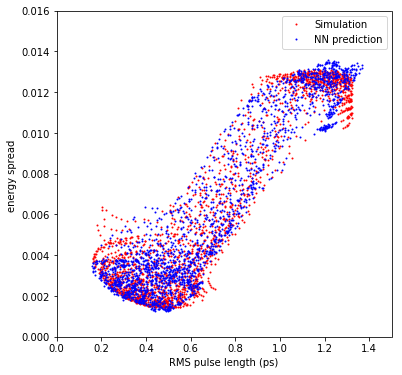

In [0]:
## plot energy spread VS temporal length

plt.figure(figsize=(6,6))
plt.plot(rms_y_simulation, rms_x_simulation,'ro', label = 'Simulation',markersize=1)
plt.plot(rms_y_prediction, rms_x_prediction,'bo',label = 'NN prediction',markersize=1)

plt.legend()
plt.axis([0,1.5,0,0.016])

plt.xlabel('RMS pulse length (ps)')
plt.ylabel('energy spread ')

##Phase space prediction using a specified parameter set
phase space prediction using a specified parameter set can be made using the trained Neural Network. 


sol = 3.0, phi = -100, Eb = -1.6


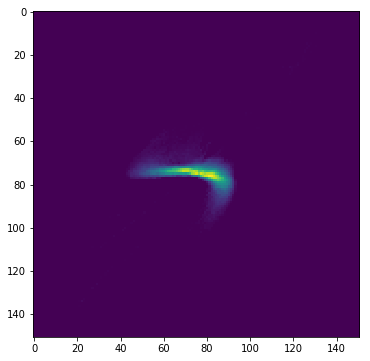

In [0]:
# prediction using a specified parameter set

sol = 3.0
phi = -100
Eb = -1.6


sol_norm = (sol-avgx[0])/stdx[0]
phi_norm = (phi-avgx[1])/stdx[1]
Eb_norm = (Eb-avgx[2])/stdx[2]

x_specify = np.array([[ sol_norm , phi_norm , Eb_norm]])
prediction_specify = model.predict(x_specify)
plt.figure(figsize=(6,6))
#plt.subplot(1,2,1)

img_predict = (prediction_specify[0].reshape(151,151)).T
img_med = ndimage.median_filter(img_predict,1)
plt.imshow(img_med)  #prediction, y need to be reshaped to be displayed

print ("sol = " + str(sol) +", phi = " + str(phi) + ", Eb = " + str(Eb))